# Modelo RANDOM FOREST

In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import os

In [2]:
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)
# c:\Users\Fran\Documents\2025-2_Seminario2\Uso-de-Inteligencia-Artificial-Geoespacial-para-Clasificar-Coberturas-Terrestres-en-Costa-Rica\dataset\PuntosMuestra_CR_2023.csv

In [3]:
# Contar instancias por categoría (en todo el dataset)
conteo_total = df["CATEGORIA"].value_counts().sort_index()
print("Instancias por categoría (dataset completo):\n", conteo_total)

Instancias por categoría (dataset completo):
 CATEGORIA
1      8197
2         2
3     15227
4      1118
6      1181
7      1373
10     2103
Name: count, dtype: int64


## Limpieza

### Quitar categoria
La categoria 2 tiene solo 2 instancias, por lo que se descarta

In [4]:
# Quitar valores de la CATEGORIA = 2
df_filtrado = df[df["CATEGORIA"] != 2]

y = df_filtrado["CATEGORIA"]
X = df_filtrado.drop(columns=["CATEGORIA", "lon", "lat", "year"])

## Definir modelo

### Dividir los datos
Se dividen los datos en entrenamiento y prueba.

In [5]:
# Dividir  los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)


In [6]:
# Conteo en train
conteo_train = y_train.value_counts().sort_index()
print("Instancias por categoría en TRAIN:\n", conteo_train)

# Conteo en test
conteo_test = y_test.value_counts().sort_index()
print("\nInstancias por categoría en TEST:\n", conteo_test)

Instancias por categoría en TRAIN:
 CATEGORIA
1      5738
3     10659
4       782
6       827
7       961
10     1472
Name: count, dtype: int64

Instancias por categoría en TEST:
 CATEGORIA
1     2459
3     4568
4      336
6      354
7      412
10     631
Name: count, dtype: int64


### Balancear la cantidad de instancias
Las categorias 3 y 1 son demasiadas a comparación de las otras, por lo que es necesario balancear las muestras

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Usar metodo submuestreo UNDERSAMPLING
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)

In [8]:
# Conteo en train
conteo_train = y_train.value_counts().sort_index()
print("Instancias por categoría en TRAIN:\n", conteo_train)

# Conteo en test
conteo_test = y_test.value_counts().sort_index()
print("\nInstancias por categoría en TEST:\n", conteo_test)

Instancias por categoría en TRAIN:
 CATEGORIA
1     782
3     782
4     782
6     782
7     782
10    782
Name: count, dtype: int64

Instancias por categoría en TEST:
 CATEGORIA
1     336
3     336
4     336
6     336
7     336
10    336
Name: count, dtype: int64


### Usar modelo Random Forest

In [9]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

## Entrenamiento y medir su tiempo

In [10]:
# Entrenamiento
t0_fit = time.perf_counter()
rf.fit(X_train, y_train)
t1_fit = time.perf_counter()

# Prueba
t0_pred = time.perf_counter()
y_pred = rf.predict(X_test)
t1_pred = time.perf_counter()

# Medicion de tiempos
train_time_s = t1_fit - t0_fit
pred_time_s  = t1_pred - t0_pred
pred_ms_per_sample = (pred_time_s / len(y_test)) * 1000


## Prueba y Resultados

In [13]:
oa   = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average="macro")
cm   = confusion_matrix(y_test, y_pred, labels=np.sort(y.unique()))

print("=== RANDOM FOREST ===")
print(f"Instancias: total={len(y_train) + len(y_test)}, train={len(y_train)}, test={len(y_test)}")
print(f"Tiempo entrenamiento: {train_time_s:.2f} s")
print(f"Tiempo inferencia total: {pred_time_s:.3f} s  "
      f"({pred_ms_per_sample:.3f} ms/muestra)")
print(f"OA (accuracy): {oa:.3f}")
print(f"F1-macro: {f1m:.3f}")
print("Etiquetas (orden en matriz):", np.sort(y.unique()).tolist())
print("Matriz de confusión:\n", cm)

=== RANDOM FOREST ===
Instancias: total=6708, train=4692, test=2016
Tiempo entrenamiento: 0.37 s
Tiempo inferencia total: 0.050 s  (0.025 ms/muestra)
OA (accuracy): 0.823
F1-macro: 0.823
Etiquetas (orden en matriz): [1, 3, 4, 6, 7, 10]
Matriz de confusión:
 [[302  24   0   3   3   4]
 [ 21 283   0   1   3  28]
 [  7   0 318  10   0   1]
 [  5   3  10 259  33  26]
 [ 22  14   1  14 245  40]
 [ 13  28   0  13  29 253]]


### Matriz de confusion

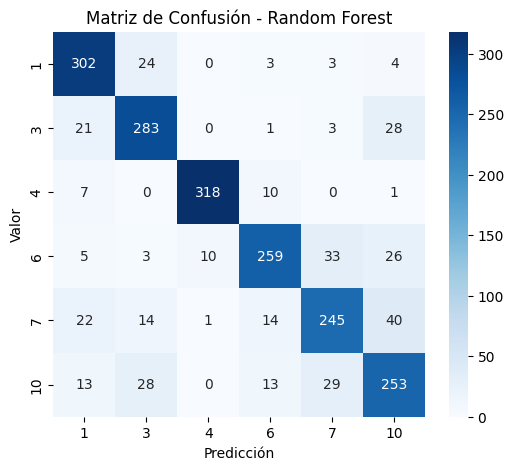

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- calcular matriz de confusión con los últimos resultados ---
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicción")
plt.ylabel("Valor")
plt.title("Matriz de Confusión - Random Forest")
plt.show()


# Registrar informacion

In [ ]:
import sys
sys.path.append("..")
import importlib, utils_log
importlib.reload(utils_log)
from utils_log import log_row

carpeta_actual = ruta_carpeta_actual.split("\\")[-1]
dataset_utilizado = csv_path.split("\\")[-1]

log_row(
  script="20250901_PruebasBalanceadasRF.ipynb",
  algoritmo="RandomForest",
  dataset=dataset_utilizado,
  clases_removidas=[2],
  seed=42,
  n_train=len(y_train), n_test=len(y_test),
  n_features=X.shape[1], num_classes=len(sorted(y.unique())),
  fit_seconds=train_time_s,                     # tiempo de rf.fit(...)
  pred_seconds=pred_time_s,                   # tiempo de rf.predict(...)
  ms_per_sample=(pred_time_s/len(y_test))*1000,
  OA=oa, F1_macro=f1m,
  carpeta=carpeta_actual
)